## Training Risk-Aware-VAE

### 1: Load MNIST as example

In [1]:
import torch
from dataset import read_mnist
from torch.utils.data import DataLoader
from utils import *

torch.manual_seed(2)

In [2]:
mnist_train, mnist_val, mnist_test = read_mnist()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

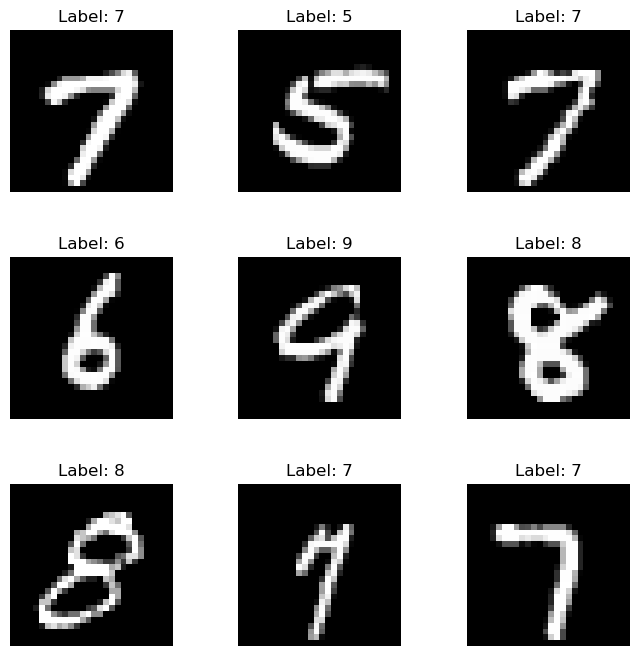

In [3]:
# some visualizations
train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
visualize_dataset_in_grid(train_features, train_labels)

### 2: Experiments

In [4]:
from backbone import VAE, vanilla_config, two_layer_config

def train_mnist(z_dim, config, risk_aware, epochs=5, risk_q=0.5, show_config=False):
    model = VAE(28 * 28, z_dim, config, device=device, risk_aware=risk_aware, risk_q=risk_q)
    if show_config:
        print(model.model)
    model.fit(mnist_train, mnist_val, epochs=epochs)
    return model

In [5]:
vae_a = train_mnist(20, vanilla_config, risk_aware="neutral")

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:18<00:00, 41.39it/s]


Epoch: 1, train loss: 154.2767, dev loss: 125.3804


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:17<00:00, 43.73it/s]


Epoch: 2, train loss: 119.5263, dev loss: 116.1227


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 48.66it/s]


Epoch: 3, train loss: 113.7238, dev loss: 112.4905


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 47.76it/s]


Epoch: 4, train loss: 111.0355, dev loss: 110.4353


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:17<00:00, 43.53it/s]


Epoch: 5, train loss: 109.4074, dev loss: 109.1101


In [6]:
vae_b = train_mnist(2, two_layer_config, risk_aware="neutral")

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:18<00:00, 40.41it/s]


Epoch: 1, train loss: 180.1437, dev loss: 165.0075


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:18<00:00, 40.23it/s]


Epoch: 2, train loss: 160.8094, dev loss: 158.4367


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 37.44it/s]


Epoch: 3, train loss: 156.5429, dev loss: 155.5839


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:19<00:00, 38.36it/s]


Epoch: 4, train loss: 154.0770, dev loss: 153.6433


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:19<00:00, 39.07it/s]


Epoch: 5, train loss: 152.2352, dev loss: 151.8201


Sanity check

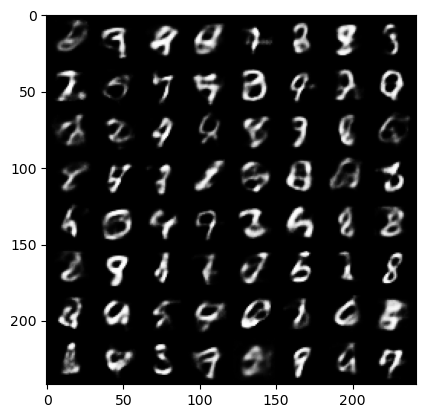

In [8]:
gen_samples = generate_img(vae_a, 20)
gen_samples = gen_samples.view(64, 1, 28, 28).cpu()
grid_show(gen_samples)

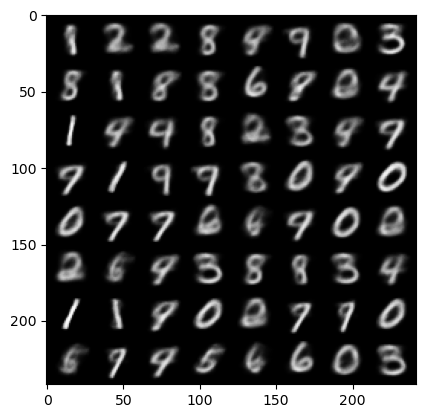

In [9]:
gen_samples = generate_img(vae_b, 2)
gen_samples = gen_samples.view(64, 1, 28, 28).cpu()
grid_show(gen_samples)

Plot reconstruction loss

In [10]:
val_dataloader = DataLoader(mnist_val, batch_size=64, shuffle=True)

In [21]:
recon_samples_a, list_recon_loss_a = compute_recon_loss(vae_a, val_dataloader)
recon_samples_b, list_recon_loss_b = compute_recon_loss(vae_b, val_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 101.51it/s]


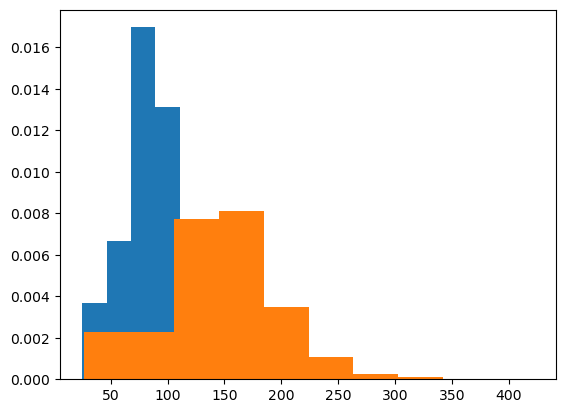

In [22]:
plot_recon_loss(reorder(list_recon_loss_a, by="image"), reorder(list_recon_loss_b, by="image"))

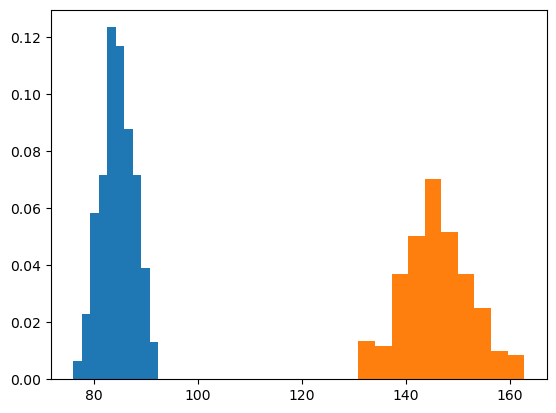

In [23]:
plot_recon_loss(reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_b, by="batch"))

Plot images in best batch

In [24]:
best_batch_a, best_batch_loss_a = best_batch(recon_samples_a, reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_a, by="image_nested"))
best_batch_b, best_batch_loss_b = best_batch(recon_samples_b, reorder(list_recon_loss_b, by="batch"), reorder(list_recon_loss_b, by="image_nested"))

Loss on best batch: 76.049675
Loss on best batch: 130.87941


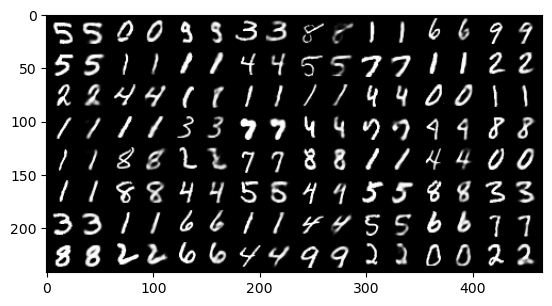

In [25]:
plot_best_batch(best_batch_a)

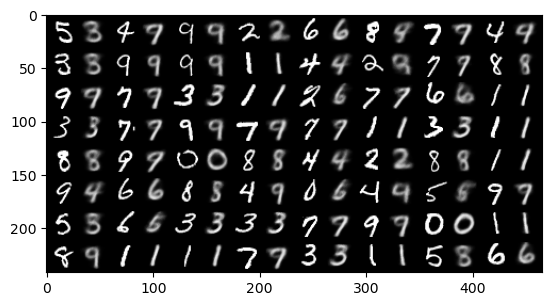

In [26]:
plot_best_batch(best_batch_b)

2 sample t-test for mean reconstruction loss in best batches

In [27]:
batch_t_test(best_batch_loss_a, best_batch_loss_b)

Ttest_indResult(statistic=-8.102464957336206, pvalue=4.0044199266627576e-13)

Plot 3 best images

Reconstruction loss: 24.76495933532715


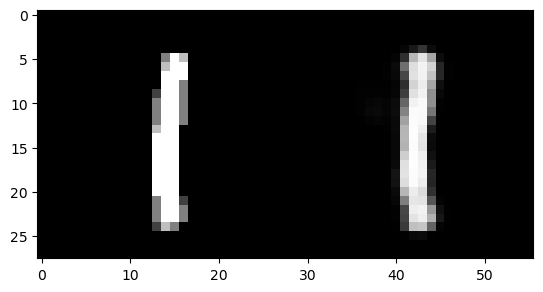

Reconstruction loss: 25.381996154785156


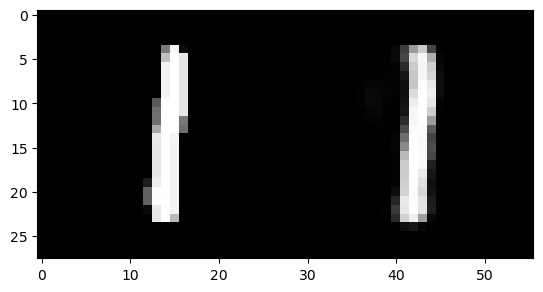

Reconstruction loss: 26.250791549682617


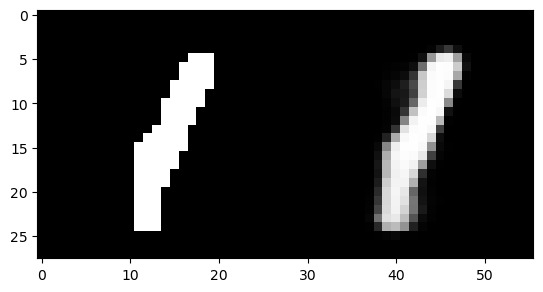

In [30]:
plot_best_images(recon_samples_a, reorder(list_recon_loss_a, by="image"))

Reconstruction loss: 26.367881774902344


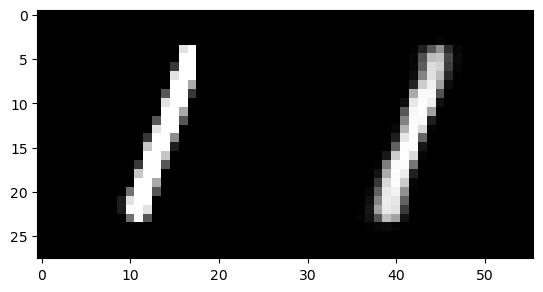

Reconstruction loss: 31.16901397705078


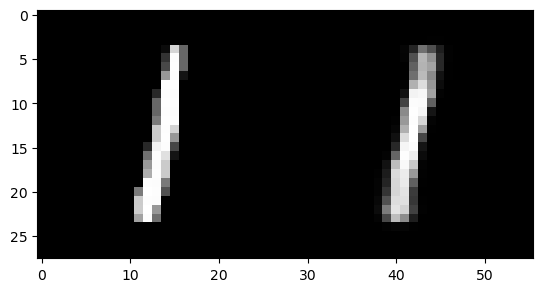

Reconstruction loss: 31.33139419555664


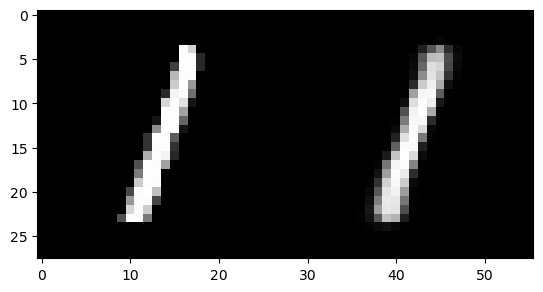

In [31]:
plot_best_images(recon_samples_b, reorder(list_recon_loss_b, by="image"))

Reconstruction loss: 29.853748321533203


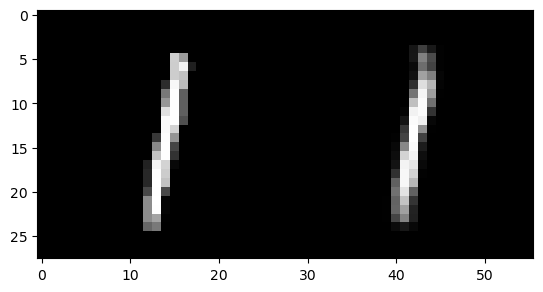

Reconstruction loss: 30.304397583007812


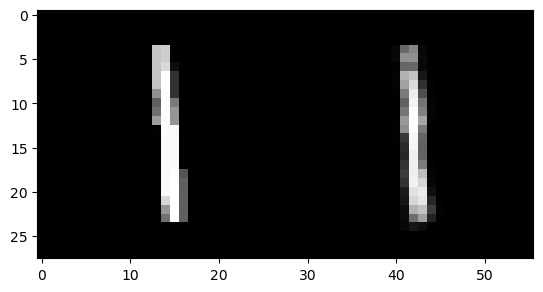

Reconstruction loss: 30.606666564941406


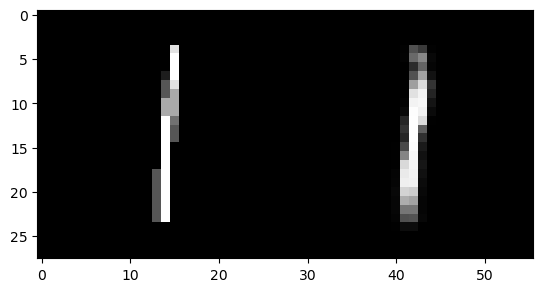

Reconstruction loss: 31.096256256103516


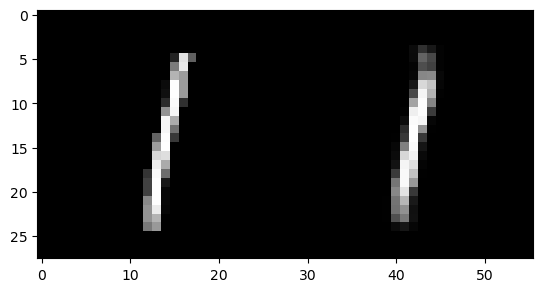

Reconstruction loss: 31.36687469482422


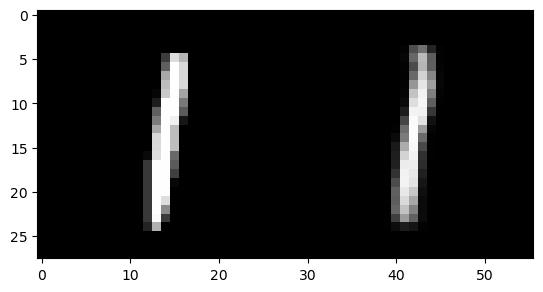

In [63]:
best_images_idx = np.argsort(recon_loss_by_img)[:5]
for idx in best_images_idx:
    print("Reconstruction loss:", recon_loss_by_img[idx].item())
    q, mod = divmod(idx, 64)
    best_batch_in, best_batch_out = list_recon_samples[q]
    best_in = best_batch_in[mod]
    best_out = best_batch_out[mod]
    best_in = best_in.view(1, 1, 28, 28).cpu()
    best_out = best_out.view(1, 1, 28, 28).cpu()
    grid_show(torch.cat((best_in, best_out), 3))
    plt.show()

### 3: Risk Aware VAE not tested

below are the experiments from the old model setup

VNet(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (var_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 87.00it/s]


Epoch: 1, train loss: 139.6798, dev loss: 123.5515


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 83.32it/s]


Epoch: 2, train loss: 119.2660, dev loss: 116.5811


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 76.62it/s]


Epoch: 3, train loss: 113.3762, dev loss: 112.3407


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 72.92it/s]


Epoch: 4, train loss: 109.8430, dev loss: 108.9664


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 78.11it/s]


Epoch: 5, train loss: 107.5455, dev loss: 107.0992


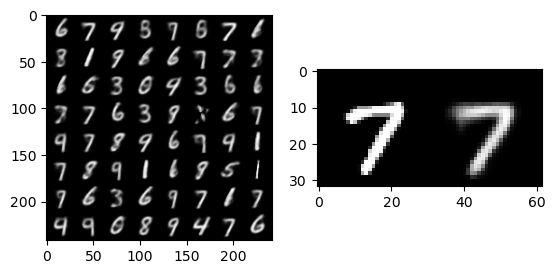

In [6]:
vae_rs = train_mnist(2, two_layer_config, risk_aware="seeking", epochs=5)

VNet(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (var_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 86.72it/s]


Epoch: 1, train loss: 212.7552, dev loss: 195.3021


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 85.62it/s]


Epoch: 2, train loss: 191.8712, dev loss: 189.4563


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 76.50it/s]


Epoch: 3, train loss: 188.0991, dev loss: 187.3712


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 76.26it/s]


Epoch: 4, train loss: 185.7132, dev loss: 185.1138


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 73.55it/s]


Epoch: 5, train loss: 183.3956, dev loss: 183.0772


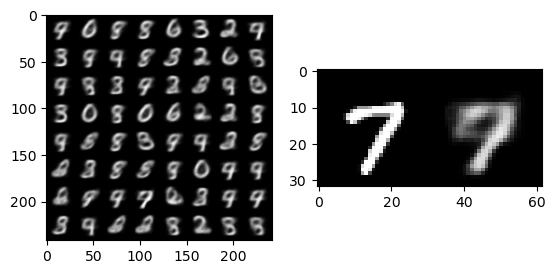

In [7]:
vae_ra = train_mnist(2, two_layer_config, risk_aware="abiding", epochs=5)